# Visual Search with MXNet Gluon and 1M Amazon Product images

**Pre-requisite**:
- MXNet: `pip install --pre mxnet-cu91`
- hnswlib (follow the guide here: https://github.com/nmslib/hnsw)

In [1]:
import mxnet as mx
from mxnet import gluon, nd
from mxnet.gluon.model_zoo import vision
import multiprocessing
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import numpy as np
import wget
import imghdr
import json
import pickle
import hnswlib
import numpy as np
import glob, os, time
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import urllib.parse
import urllib
import gzip
import os
import tempfile
import glob
from download import download_files
from os.path import join
%matplotlib inline

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Data originally from here:
http://jmcauley.ucsd.edu/data/amazon/

*Image-based recommendations on styles and substitutes
J. McAuley, C. Targett, J. Shi, A. van den Hengel
SIGIR, 2015*

## Downloading images
We only use a subset of the total number of images, here 1M
(it takes about 40 minutes to download all the data on an ec2 instance)

In [2]:
subset_num = 100000

Beware, if using the full dataset this will download **300GB** of images, make sure you have the appropriate hardware and connexion!
Alternatively, just set `images_path` to a directory containing images following this format `ID.jpg`

In [3]:
data_path = 'metadata.json'
images_path = join('/data','amazon_images_subset')

Download the metadata.json file that contains the URL of the images

In [4]:
if not os.path.isfile(data_path):
    # Downloading the metadata, 3.1GB, unzipped 9GB
    !wget -nv https://s3.us-east-2.amazonaws.com/mxnet-public/stanford_amazon/metadata.json.gz
    !gzip -d metadata.json.gz

if not os.path.isdir(images_path):
    os.makedirs(images_path)

In [5]:
num_lines = 0
num_lines = sum(1 for line in open(data_path))
assert num_lines >= subset_num, "Subset needs to be smaller or equal to total number of example"

In [6]:
def parse(path, num_cpu, modulo):
    g = open(path, 'r')
    for i, l in enumerate(g):
        if (i >= num_lines - subset_num and i%num_cpu == modulo):
            yield eval(l)

In [7]:
def download_files(modulo):
    for i, data in enumerate(parse(data_path, NUM_CPU, modulo)):
        if (i%1000000==0):
            print(i)
        if 'imUrl' in data and data['imUrl'] is not None and 'categories' in data and data['imUrl'].split('.')[-1] == 'jpg':
            url = data['imUrl']
            try:
                path = os.path.join(images_path, data['asin']+'.jpg')
                if not os.path.isfile(path):
                    file = urllib.request.urlretrieve(url, path)
            except:
                print("Error downloading {}".format(url))

Downloading the images using 10 times more processes than cores

In [8]:
NUM_CPU = multiprocessing.cpu_count()*10

In [9]:
# pool = multiprocessing.Pool(processes=NUM_CPU)
# results = pool.map(download_files, list(range(NUM_CPU)))

In [10]:
# Removing all the fake jpegs
list_files = glob.glob(os.path.join(images_path, '**.jpg'))
for file in list_files:
    if imghdr.what(file) != 'jpeg':
        print('Removed {} it is a {}'.format(file, imghdr.what(file)))
        os.remove(file)

## Generate the image embeddings

In [11]:
BATCH_SIZE = 256
EMBEDDING_SIZE = 512
SIZE = (224, 224)
MEAN_IMAGE= mx.nd.array([0.485, 0.456, 0.406])
STD_IMAGE = mx.nd.array([0.229, 0.224, 0.225])

### Featurizer
We use a pre-trained model from the model zoo

In [12]:
ctx = mx.gpu() if len(mx.test_utils.list_gpus()) else mx.cpu()

Networks from the model-zoo follow the convention that the features are on the `.features` property and output on the `.output` property. It makes it very easy to transform any pre-trained network in featurizer.

In [13]:
net = vision.resnet18_v2(pretrained=True, ctx=ctx).features

In [14]:
net

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats

### Save the pre-trained featurizer

In [15]:
net.hybridize()

In [16]:
net(mx.nd.ones((1,3,224,224), ctx=ctx))
net.export(join('mms','visualsearch'))

### Data Transform
to convert the images to a shape usable by the network

In [17]:
def transform(image, label):
    resized = mx.image.resize_short(image, SIZE[0]).astype('float32')
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    cropped /= 255.
    normalized = mx.image.color_normalize(cropped,
                                      mean=MEAN_IMAGE,
                                      std=STD_IMAGE) 
    transposed = nd.transpose(normalized, (2,0,1))
    return transposed, label

### Data Loading

In [18]:
empty_folder = tempfile.mkdtemp()
# Create an empty image Folder Data Set
dataset = ImageFolderDataset(root=empty_folder, transform=transform)

In [19]:
list_files = glob.glob(os.path.join(images_path, '**.jpg'))

In [20]:
print("[{}] images".format(len(list_files)))

[93119] images


#### Creating data files for offline inference

In [21]:
idx_ASIN = []
for file in list_files:
    idx_ASIN.append(file.split('/')[-1].split('.')[0])

In [22]:
ASINs = set(idx_ASIN)    

In [23]:
def get_ASIN_data(modulo):
    ASIN_data = {}
    file = open(data_path, 'r')
    for i, line in enumerate(file):
        if i % NUM_CPU == modulo:
            data = eval(line)
            if i % 1000000 == 0:
                print("[{}] product data processed".format(i))
            if data['asin'] in ASINs:
                ASIN_data[data['asin']] = {
                    'price':data['price'] if 'price' in data else 'NA',
                    'url':data['imUrl'],
                    'title': data['title'] if 'title' in data else 'NA',
                    'ASIN':data['asin']
                }
    return ASIN_data

In [24]:
# NUM_CPU = 1
# pool = multiprocessing.Pool(processes=NUM_CPU)
# results = pool.map(get_ASIN_data, list(range(NUM_CPU)))

In [25]:
# ASIN_data = { k: v for d in results for k, v in d.items() }

In [26]:
idx_asin_file = join('mms','idx_ASIN.pkl')
ASIN_data_file = join('mms', 'ASIN_data.pkl')

In [27]:
# pickle.dump(idx_ASIN, open(idx_asin_file, 'wb'), protocol=2)
# pickle.dump(ASIN_data, open(ASIN_data_file, 'wb'), protocol=2)

Because of the data validation and invalid URL, our actual subset is smaller than the one requested

In [28]:
idx_ASIN = pickle.load(open(idx_asin_file, 'rb'))
ASIN_data = pickle.load(open(ASIN_data_file, 'rb'))

In [29]:
# We map the files to the dataset

In [30]:
dataset.items = list(zip(list_files, [0]*len(list_files)))

In [31]:
list_files

['/data\\amazon_images_subset\\B00JAL02YY.jpg',
 '/data\\amazon_images_subset\\B00JALVR52.jpg',
 '/data\\amazon_images_subset\\B00JALZ6ZY.jpg',
 '/data\\amazon_images_subset\\B00JAM8MI6.jpg',
 '/data\\amazon_images_subset\\B00JAMA5HC.jpg',
 '/data\\amazon_images_subset\\B00JAMK8TM.jpg',
 '/data\\amazon_images_subset\\B00JAMWUPM.jpg',
 '/data\\amazon_images_subset\\B00JAMXFY2.jpg',
 '/data\\amazon_images_subset\\B00JAMY1K4.jpg',
 '/data\\amazon_images_subset\\B00JAN0D5K.jpg',
 '/data\\amazon_images_subset\\B00JAN0M8I.jpg',
 '/data\\amazon_images_subset\\B00JAN174G.jpg',
 '/data\\amazon_images_subset\\B00JAN1WT6.jpg',
 '/data\\amazon_images_subset\\B00JAN2XN0.jpg',
 '/data\\amazon_images_subset\\B00JAN4C2K.jpg',
 '/data\\amazon_images_subset\\B00JAN4PAE.jpg',
 '/data\\amazon_images_subset\\B00JAN4UAO.jpg',
 '/data\\amazon_images_subset\\B00JAN4VHG.jpg',
 '/data\\amazon_images_subset\\B00JAN4VSK.jpg',
 '/data\\amazon_images_subset\\B00JAN6U16.jpg',
 '/data\\amazon_images_subset\\B00JAN7S6

We load the dataset in a dataloader with as many workers as CPU cores

In [32]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, last_batch='keep', shuffle=False, num_workers=multiprocessing.cpu_count())

### Featurization

In [33]:
features = np.zeros((len(dataset), EMBEDDING_SIZE), dtype=np.float32)

In [34]:
# %%time
# tick = time.time()
# n_print = 100
# j = 0
# for i, (data, label) in enumerate(dataloader):
#     data = data.as_in_context(ctx)
#     if i%n_print == 0 and i > 0:
#         print("{0} batches, {1} images, {2:.3f} img/sec".format(i, i*BATCH_SIZE, BATCH_SIZE*n_print/(time.time()-tick)))
#         tick = time.time()
#     output = net(data)
#     features[(i)*BATCH_SIZE:(i+1)*max(BATCH_SIZE, len(output)), :] = output.asnumpy().squeeze()

## Create the search index

In [35]:
# # Number of elements in the index
num_elements = len(features)
labels_index = np.arange(num_elements)

In [36]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = EMBEDDING_SIZE) # possible options are l2, cosine or ip

In [37]:
%%time 
# Initing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 100, M = 16)

# Element insertion (can be called several times):
int_labels = p.add_items(features, labels_index)

Wall time: 1min 37s


In [38]:
# Controlling the recall by setting ef:
# p.set_ef(300) # ef should always be > k

In [39]:
# p.save_index(join('mms', 'index.idx'))

In [40]:
p.load_index(join('mms','index.idx'))

### Testing

We test the results by sampling random images from the dataset and searching their K-NN

In [41]:
feature_file = join('mms','feature.pkl')

features = pickle.load(open(feature_file, 'rb'))

In [42]:
def plot_predictions(images):
    gs = gridspec.GridSpec(3, 3)
    fig = plt.figure(figsize=(15, 15))
    gs.update(hspace=0.1, wspace=0.1)
    for i, (gg, image) in enumerate(zip(gs, images)):
        gg2 = gridspec.GridSpecFromSubplotSpec(10, 10, subplot_spec=gg)
        ax = fig.add_subplot(gg2[:,:])
        ax.imshow(image, cmap='Greys_r')
        ax.tick_params(axis='both',       
                       which='both',      
                       bottom='off',      
                       top='off',         
                       left='off',
                       right='off',
                       labelleft='off',
                       labelbottom='off') 
        ax.axes.set_title("result [{}]".format(i))
        if i == 0:
            plt.setp(ax.spines.values(), color='red')
            ax.axes.set_title("SEARCH".format(i))

In [43]:
def search(N, k):
    # Query dataset, k - number of closest elements (returns 2 numpy arrays)
    q_labels, q_distances = p.knn_query([features[N]], k = k+1)
    images = [plt.imread(dataset.items[label][0]) for label in q_labels[0][1:]]
    plot_predictions(images)

### Random testing

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Wall time: 192 ms


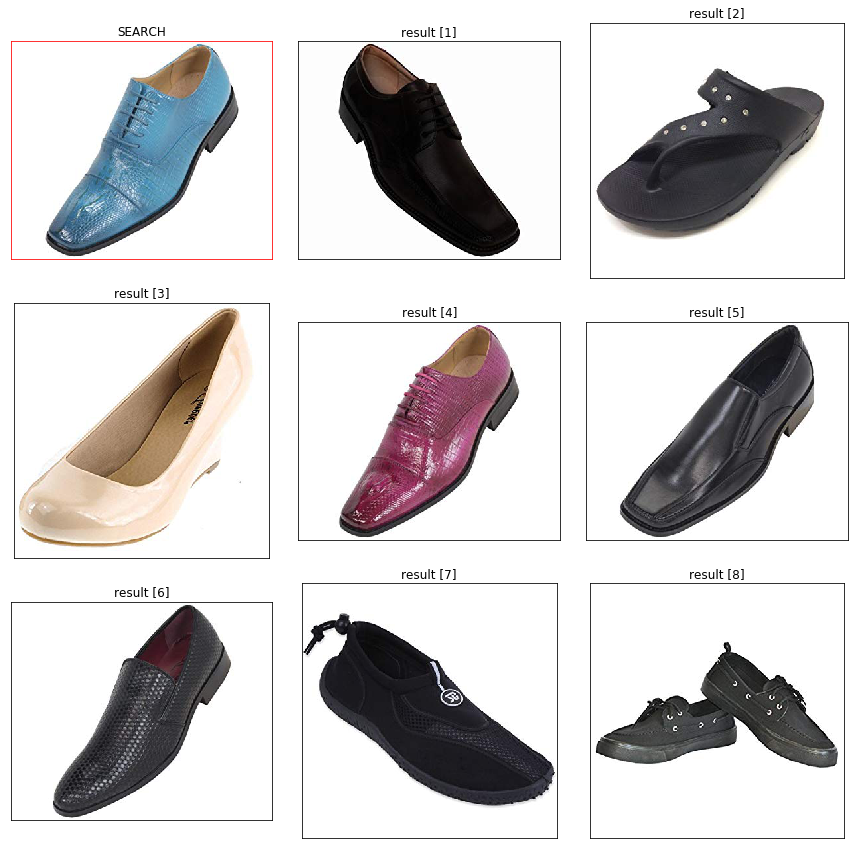

In [44]:
%%time
index = np.random.randint(0,len(features))
k = 10
search(119, k)

## Deep Learning pre-processing and refinement

In [45]:
import mxnet as mx
import numpy as np
import gluoncv as gcv
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from mxnet import nd, image
from mxnet.gluon.data.vision import transforms
from gluoncv.model_zoo import get_model
from gluoncv.utils import viz, download

### Load an image

In [46]:
path = 'test.jpg'

In [47]:
x, img = gcv.data.transforms.presets.ssd.load_test(path, short=512)

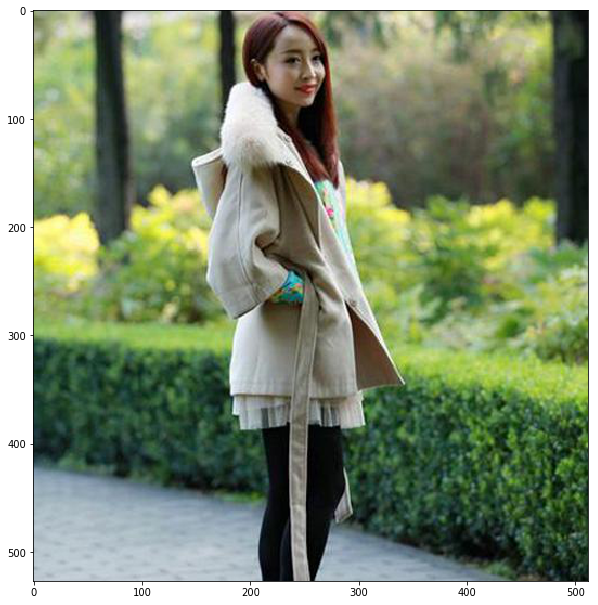

In [48]:
viz.plot_image(img)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [49]:
image = plt.imread(path)[:,:,:3]
print(type(plt.imread(path)),plt.imread(path).shape,image.shape)
image_t, _ = transform(nd.array(image), 1)
output = net(image_t.expand_dims(axis=0).as_in_context(ctx))
labels, distances = p.knn_query([output.asnumpy().reshape(-1,)], k = 6)
images = [image]
images += [plt.imread(dataset.items[label][0]) for label in labels[0][1:]]

<class 'numpy.ndarray'> (502, 488, 3) (502, 488, 3)


In [50]:
type(images[1])

numpy.ndarray

C:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


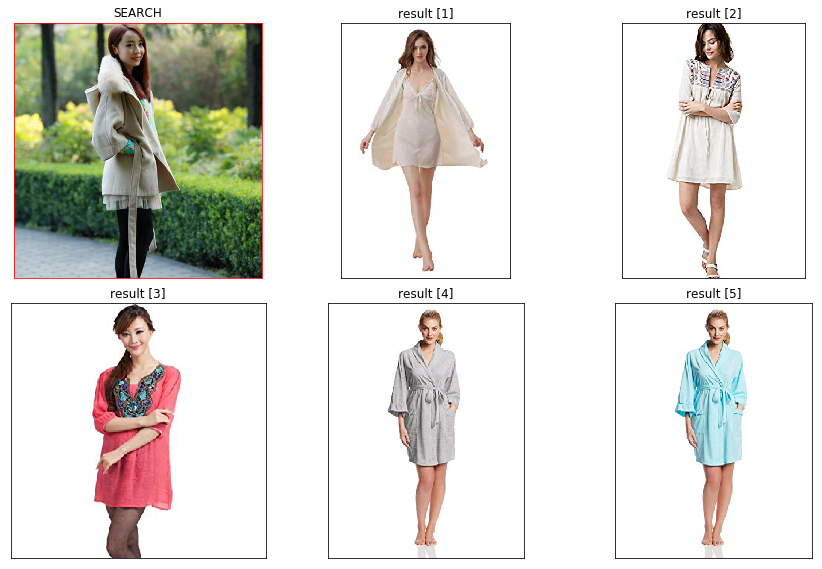

In [51]:
plot_predictions(images)

## Object detection

In [52]:
ASIN_data

{'B00JAN4PAE': {'price': 9.9,
  'url': 'http://ecx.images-amazon.com/images/I/31wlW7vBbWL.jpg',
  'title': 'Totes Deluxe Sweater &amp; Fabric Clothes Shaver',
  'ASIN': 'B00JAN4PAE'},
 'B00JAO2ZXW': {'price': 3.99,
  'url': 'http://ecx.images-amazon.com/images/I/51xx1z5F7rL._BO2,204,203,200_PIsitb-sticker-v3-big,TopRight,0,-55_SX278_SY278_PIkin4,BottomRight,1,22_AA300_SH20_OU01_.jpg',
  'title': 'NA',
  'ASIN': 'B00JAO2ZXW'},
 'B00JAO7866': {'price': 1.95,
  'url': 'http://ecx.images-amazon.com/images/I/215sMSWxYqL._SX300_.jpg',
  'title': 'Wristband Kit',
  'ASIN': 'B00JAO7866'},
 'B00JAODFRC': {'price': 9.99,
  'url': 'http://ecx.images-amazon.com/images/I/51OpVsTUEgL._SX342_.jpg',
  'title': 'John Deere Green Cloth and Mesh Cap',
  'ASIN': 'B00JAODFRC'},
 'B00JAOAIZE': {'price': 59.99,
  'url': 'http://ecx.images-amazon.com/images/I/413A3c-3T6L._SX395_.jpg',
  'title': 'Bolano Mens Exotic Faux Eel Print Oxford Dress Shoe in Grey and Black: Style Brayden Grey -011',
  'ASIN': 'B00JAO

In [53]:
ASIN_data['B00K1TMUIU']

KeyError: 'B00K1TMUIU'